In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import json
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, Concatenate, Multiply, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2024-06-02 09:31:14.001609: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 09:31:14.001718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 09:31:14.160552: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the data
comments = pd.read_csv('/kaggle/input/my-dataset/comment.csv')
novels = pd.read_csv('/kaggle/input/my-dataset/novel.csv')

comments.dropna(subset=['accountId', 'novelId', 'commentId'], inplace=True)
novels.dropna(subset=['novelId'], inplace=True)

comments['accountId'] = comments['accountId'].astype(np.int64)
comments['novelId'] = comments['novelId'].astype(np.int64)
novels['novelId'] = novels['novelId'].astype(np.int64)

# Merge the category information into comments
merge = comments.merge(novels[['novelId', 'categoryName']], left_on='novelId', right_on='novelId', how='left')

Chi2: 2010.4852517033696, p-value: 0.0, degrees of freedom: 68


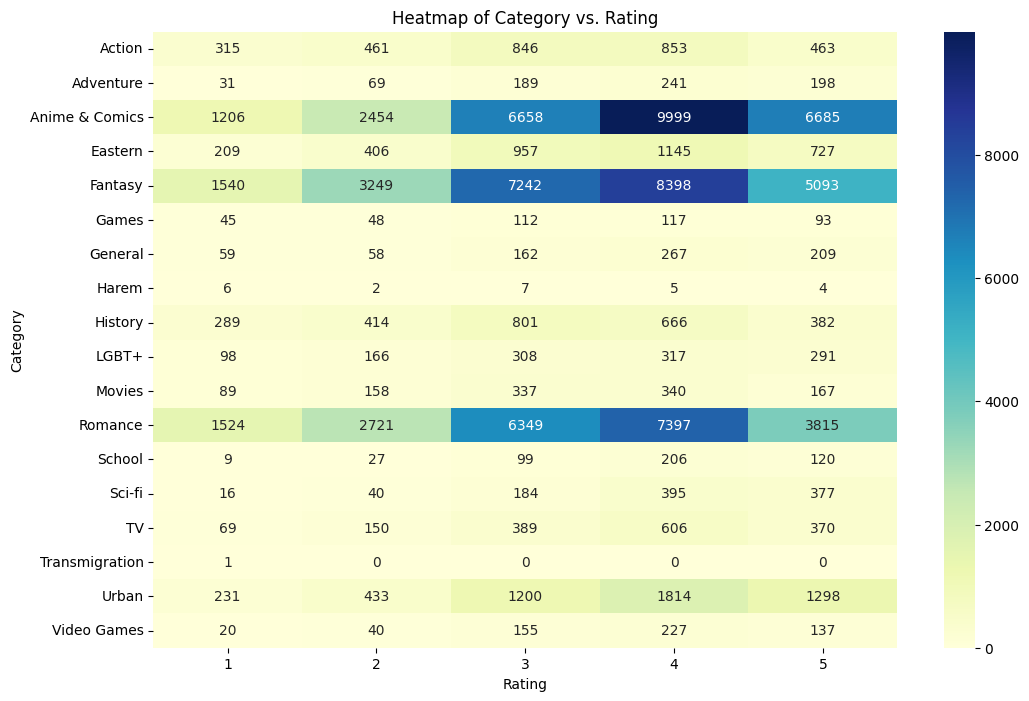

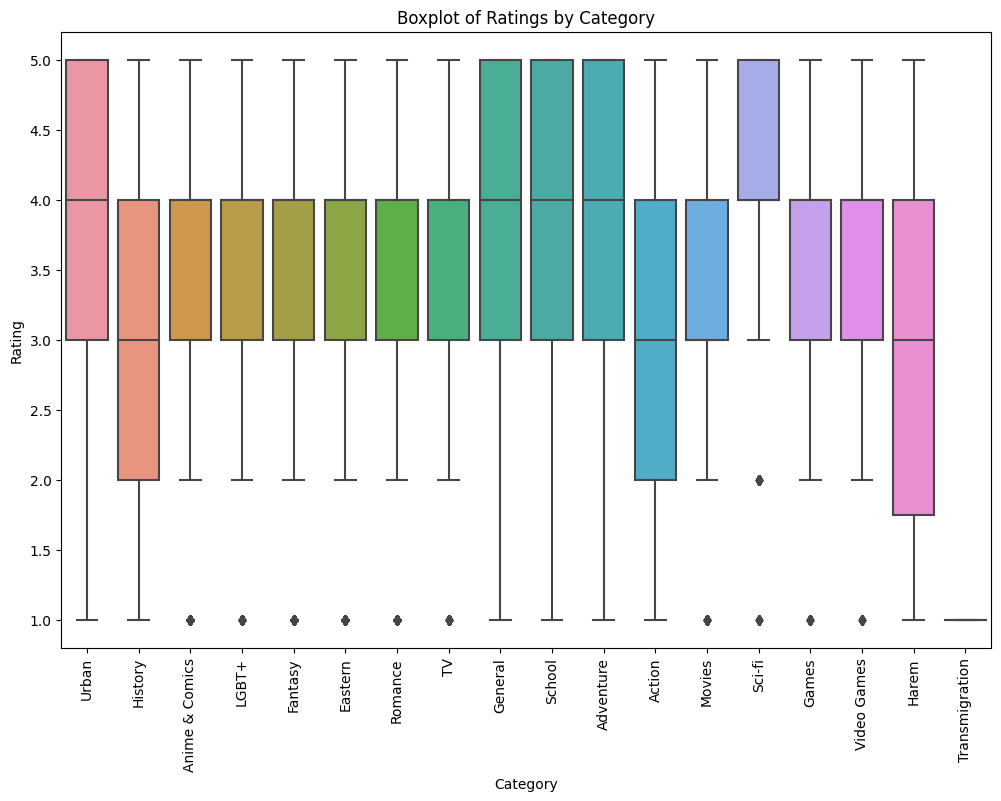

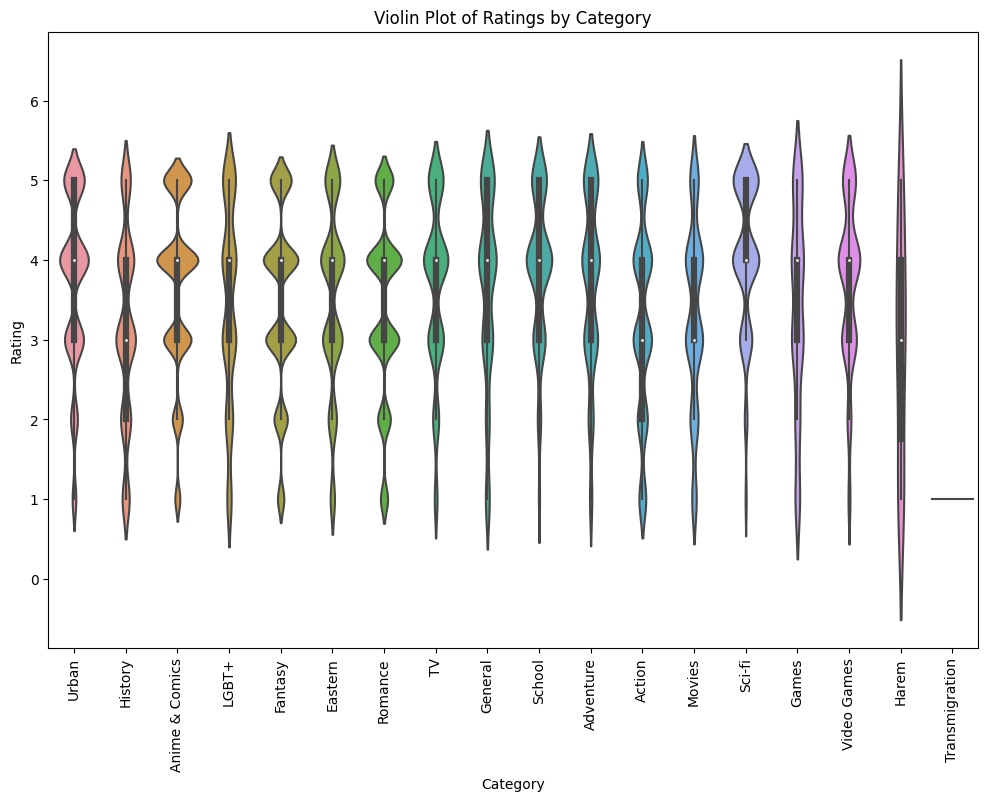

In [3]:
# Create a crosstab of category and rating
crosstab = pd.crosstab(merge['categoryName'], merge['rating'])

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(crosstab)
print(f"Chi2: {chi2}, p-value: {p}, degrees of freedom: {dof}")

# Visualize the relationship using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Category vs. Rating')
plt.xlabel('Rating')
plt.ylabel('Category')
plt.show()

# Visualize the distribution of ratings for each category using a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='categoryName', y='rating', data=merge)
plt.title('Boxplot of Ratings by Category')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.show()

# Visualize the distribution of ratings for each category using a violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='categoryName', y='rating', data=merge)
plt.title('Violin Plot of Ratings by Category')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.show()

In [4]:
# Encode user and novel IDs
user_encoder = LabelEncoder()
novel_encoder = LabelEncoder()
category_encoder = LabelEncoder()

comments['user'] = user_encoder.fit_transform(comments['accountId'])
comments['novel'] = novel_encoder.fit_transform(comments['novelId'])

# Fit the category encoder on all categories
novels['category'] = category_encoder.fit_transform(novels['categoryName'])

# Merge the category information into comments
comments = comments.merge(novels[['novelId', 'category']], left_on='novelId', right_on='novelId', how='left')

# Normalize ratings
ratings = comments[['user', 'novel', 'category', 'rating']].astype(np.int64)

# Split the data into training and testing sets
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

train_users = train_data['user'].values
train_novels = train_data['novel'].values
train_categories = train_data['category'].values
train_ratings = train_data['rating'].values

test_users = test_data['user'].values
test_novels = test_data['novel'].values
test_categories = test_data['category'].values
test_ratings = test_data['rating'].values

# Define the model with chosen hyperparameters
embedding_dim = 64
dropout_rate = 0.4
dense_units = 64
learning_rate = 0.0001
reg_value = 0.01
regularization = l2(reg_value)

num_users = len(user_encoder.classes_)
num_novels = len(novel_encoder.classes_)
num_categories = len(category_encoder.classes_)

user_input = Input(shape=(1,), dtype='int32', name='user_input')
novel_input = Input(shape=(1,), dtype='int32', name='novel_input')
category_input = Input(shape=(1,), dtype='int32', name='category_input')

user_embedding_gmf = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding_gmf')(user_input)
novel_embedding_gmf = Embedding(input_dim=num_novels, output_dim=embedding_dim, name='novel_embedding_gmf')(novel_input)
category_embedding_gmf = Embedding(input_dim=num_categories, output_dim=embedding_dim, name='category_embedding_gmf')(category_input)

user_vec_gmf = Flatten()(user_embedding_gmf)
novel_vec_gmf = Flatten()(novel_embedding_gmf)
category_vec_gmf = Flatten()(category_embedding_gmf)

gmf = Multiply()([user_vec_gmf, novel_vec_gmf, category_vec_gmf])

user_embedding_mlp = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding_mlp')(user_input)
novel_embedding_mlp = Embedding(input_dim=num_novels, output_dim=embedding_dim, name='novel_embedding_mlp')(novel_input)
category_embedding_mlp = Embedding(input_dim=num_categories, output_dim=embedding_dim, name='category_embedding_mlp')(category_input)

user_vec_mlp = Flatten()(user_embedding_mlp)
novel_vec_mlp = Flatten()(novel_embedding_mlp)
category_vec_mlp = Flatten()(category_embedding_mlp)

mlp = Concatenate()([user_vec_mlp, novel_vec_mlp, category_vec_mlp])
mlp = Dense(dense_units, kernel_regularizer=regularization)(mlp)
mlp = LeakyReLU(negative_slope=0.1)(mlp)
mlp = BatchNormalization()(mlp)
mlp = Dropout(dropout_rate)(mlp)
mlp = Dense(dense_units // 2, kernel_regularizer=regularization)(mlp)
mlp = LeakyReLU(negative_slope=0.1)(mlp)
mlp = BatchNormalization()(mlp)
mlp = Dropout(dropout_rate)(mlp)
mlp = Dense(dense_units // 4, kernel_regularizer=regularization)(mlp)
mlp = LeakyReLU(negative_slope=0.1)(mlp)
mlp = BatchNormalization()(mlp)

neumf = Concatenate()([gmf, mlp])
output = Dense(1)(neumf)

model = Model(inputs=[user_input, novel_input, category_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae', 'mape', tf.keras.metrics.RootMeanSquaredError()])

# Early Stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

# Model Training
history = model.fit([train_users, train_novels, train_categories], train_ratings,
                    batch_size=256, epochs=100, verbose=1,
                    validation_data=([test_users, test_novels, test_categories], test_ratings),
                    callbacks=[early_stopping, reduce_lr])

model.save('recommendation_model.h5')

# Model Evaluation
eval_results = model.evaluate([test_users, test_novels, test_categories], test_ratings, verbose=1)
print(f"Test Loss: {eval_results[0]}, Test MAE: {eval_results[1]}, Test MAPE: {eval_results[2]}, Test RMSE: {eval_results[3]}")


Epoch 1/100
 50/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.5130 - mae: 3.5179 - mape: 100.1985 - root_mean_squared_error: 3.7312

I0000 00:00:1717320698.538072      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


301/301 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 15.3435 - mae: 3.5109 - mape: 99.8401 - root_mean_squared_error: 3.7124 - val_loss: 14.3816 - val_mae: 3.4214 - val_mape: 95.8297 - val_root_mean_squared_error: 3.5958 - learning_rate: 1.0000e-04
Epoch 2/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 14.4135 - mae: 3.4265 - mape: 97.6282 - root_mean_squared_error: 3.6053 - val_loss: 13.5937 - val_mae: 3.3401 - val_mape: 94.1037 - val_root_mean_squared_error: 3.5053 - learning_rate: 1.0000e-04
Epoch 3/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 13.2653 - mae: 3.2863 - mape: 94.0453 - root_mean_squared_error: 3.4629 - val_loss: 12.3823 - val_mae: 3.1900 - val_mape: 90.7317 - val_root_mean_squared_error: 3.3472 - learning_rate: 1.0000e-04
Epoch 4/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 11.8126 - mae: 3.0873 - mape: 88.3848 - root_mean_squared_error: 3.2652 - val_loss: 10.7446 - val_mae: 2.9493 - val_mape: 83.6447 - val_root_mean_squared_error: 3.1106 - learning

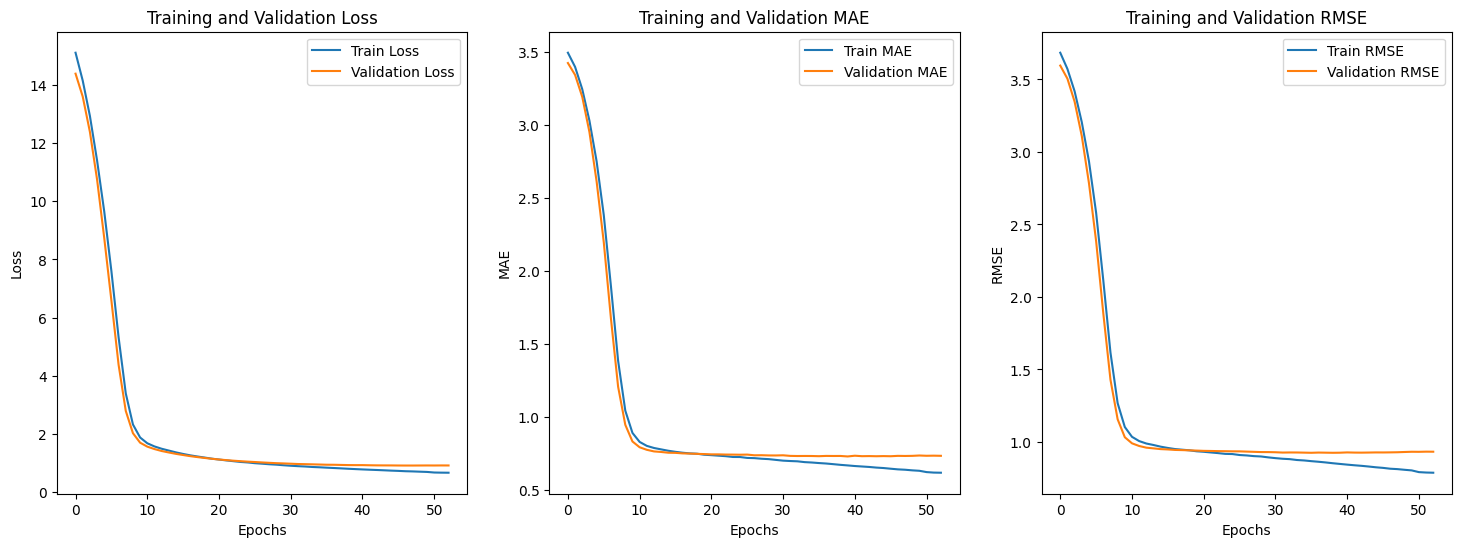

601/601 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [5]:
# Visualization of training metrics
def plot_training_history(history):
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title('Training and Validation RMSE')
    plt.legend()
    
    plt.show()

plot_training_history(history)

# Generate predicted ratings for the test set
predicted_ratings = model.predict([test_users, test_novels, test_categories])

In [6]:
novel_id_to_name = dict(zip(novels['novelId'], novels['name']))

def recommend_novels(user_id, top_n=50):
    user_index = user_encoder.transform([user_id])[0]
    novel_indices = np.arange(num_novels)
    category_indices = novels['category'].values
    
    # Get the novels that the user has already rated
    rated_novels = comments[comments['user'] == user_index]['novel'].values
    rated_novels_set = set(rated_novels)
    
    # Predict ratings for all novels
    predictions = model.predict([np.full(num_novels, user_index), novel_indices, category_indices])
    
    # Filter out novels that the user has already rated
    filtered_indices = [i for i in range(num_novels) if i not in rated_novels_set]
    filtered_predictions = predictions.flatten()[filtered_indices]
    
    # Get top N novel indices
    top_novels = np.argsort(filtered_predictions)[-top_n:][::-1]
    recommended_novels_ids = novel_encoder.inverse_transform(np.array(filtered_indices)[top_novels])
    
    # Map novel IDs to names
    recommended_novels = [(nid, novel_id_to_name[nid]) for nid in recommended_novels_ids]
    
    return recommended_novels

# Example usage
recommendations = recommend_novels('4304343304')
for novel_id, novel_name in recommendations:
    print(f"Novel ID: {novel_id}, Name: {novel_name}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Novel ID: 25402432005825805, Name: Harry Potter system in Douluo Dalu
Novel ID: 16588885305483405, Name: Playing One Piece
Novel ID: 24483559606921405, Name: DC: The Authority
Novel ID: 21720633905141705, Name: A Snake's Obsession
Novel ID: 25385059105786205, Name: in Naruto with the talent system
Novel ID: 25437599405916505, Name: Creati Hero: All-Father[Completed]
Novel ID: 22070785006351705, Name: Mad Wolf Knight(DxD)
Novel ID: 18814398306282501, Name: Reborn to Be a Movie Queen
Novel ID: 25013863306823605, Name: Overlord: So I'm a spider, so what?
Novel ID: 24753447406009105, Name: Anime mashup with omnipotent system
Novel ID: 21402509705155405, Name: ARIFURETA: The Otherworldly Alchemist
Novel ID: 20378810606920701, Name: The Runaway Wife
Novel ID: 24947961705371405, Name: Terrarian in the Dungeon
Novel ID: 14798019206730201, Name: Love Game
Novel ID: 21292822606105701, Name: Cat Demon's Seduction S2
Novel ID: 24611691505162305, Name: I Swear

In [7]:
import pandas as pd
import numpy as np

comparison_df = pd.DataFrame({
    'User': test_users,
    'Novel': test_novels,
    'Actual Rating': test_ratings,
    'Predicted Rating': predicted_ratings.flatten()
})

filtered_df = comparison_df[comparison_df['Actual Rating'].isin([3, 4, 5])]

print("Filtered DataFrame (Actual Rating 3, 4, 5):")
print(filtered_df.head(50).to_string(index=False))

print("\nOriginal DataFrame:")
print(comparison_df.head(50).to_string(index=False))

Filtered DataFrame (Actual Rating 3, 4, 5):
 User  Novel  Actual Rating  Predicted Rating
  409    998              5          4.655526
  208    454              5          4.216782
  753    749              3          4.096751
  300    876              5          2.495358
  678    955              5          3.877141
  363   1440              5          3.646539
  574   1403              4          4.043603
  369    561              5          3.121534
  485    296              4          4.068670
  538    599              3          3.484584
  415     25              5          3.576729
  838    530              4          3.505048
  451    987              4          4.109250
  425    338              4          4.085601
  680    400              4          3.754620
  246    354              5          3.858568
  651    399              3          3.868879
  240   1311              5          3.610115
  518    617              4          3.700198
  351   1174              4         

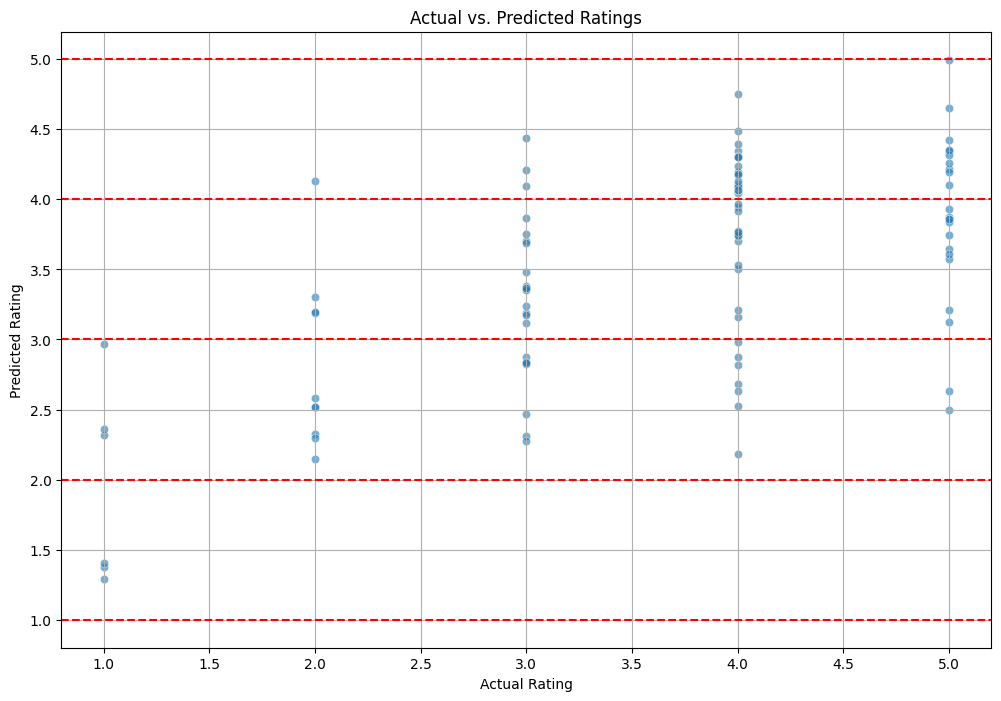

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


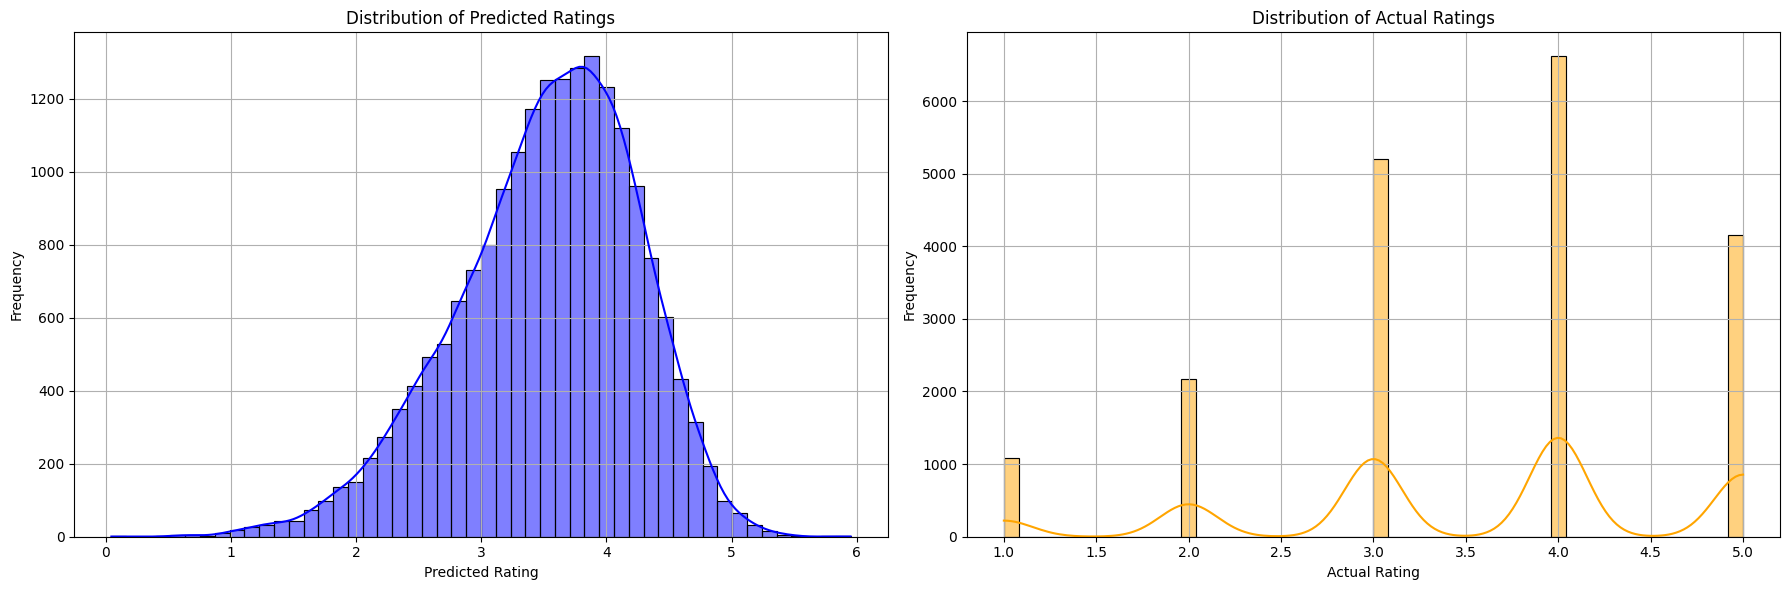

In [8]:
# Scatter plot of actual vs. predicted ratings
def plot_actual_vs_predicted(comparison_df):
    plt.figure(figsize=(12, 8))
    
    sns.scatterplot(x='Actual Rating', y='Predicted Rating', data=comparison_df, alpha=0.6)
    plt.axhline(y=1, color='r', linestyle='--')
    plt.axhline(y=2, color='r', linestyle='--')
    plt.axhline(y=3, color='r', linestyle='--')
    plt.axhline(y=4, color='r', linestyle='--')
    plt.axhline(y=5, color='r', linestyle='--')
    plt.xlabel('Actual Rating')
    plt.ylabel('Predicted Rating')
    plt.title('Actual vs. Predicted Ratings')
    plt.grid(True)
    plt.show()

def plot_distribution_of_ratings(comparison_df):
    plt.figure(figsize=(18, 6))

    # Plot the distribution of predicted ratings
    plt.subplot(1, 2, 1)
    sns.histplot(comparison_df['Predicted Rating'], kde=True, bins=50, color='blue')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Ratings')
    plt.grid(True)

    # Plot the distribution of actual ratings
    plt.subplot(1, 2, 2)
    sns.histplot(comparison_df['Actual Rating'], kde=True, bins=50, color='orange')
    plt.xlabel('Actual Rating')
    plt.ylabel('Frequency')
    plt.title('Distribution of Actual Ratings')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(comparison_df.head(100))
plot_distribution_of_ratings(comparison_df)
